In [106]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import matplotlib.pyplot as plt 
from scipy.stats import loguniform

In [109]:
dt = 1  # time step size
steps = 4096  # number of time steps
stepsCont = 2 ** 15 - steps  # for adding more steps and evolve quickly after pulse is over
SpectraNumber = 1  # number of spectra to calculate

# some conversions
times = np.linspace(0, (steps + stepsCont) * dt * 0.02419, steps + stepsCont, endpoint=False)
de = 1 / ((steps + stepsCont) * dt) * 171.2
eV = np.linspace(0, (steps + stepsCont) * de, steps + stepsCont, endpoint=False)

# Light field/pulse parameters 1.16112
frequency = 0.779
spectralwidth = 0.0002134
delay = int(steps / 2)  # time delay of pulse
aFieldStrength = .1

In [110]:
times

array([0.0000000e+00, 2.4190000e-02, 4.8380000e-02, ..., 7.9258535e+02,
       7.9260954e+02, 7.9263373e+02])

In [111]:
#define Non-interacting Hamiltonian
eigenvalues0 = np.array([0j]+[0.23-0.001j,0.25-0.001j,0.27-0.001j])
dim=len(eigenvalues0)
InitialHamiltonian = np.diag(eigenvalues0)

# Interacting/coupling part of Hamiltonian
IntH = np.zeros((dim, dim)) * 1j
IntH[0] = np.array([1] * dim)
CoupledHamiltonian = (IntH + IntH.conj().T)
for i in range(dim):
    CoupledHamiltonian[i, i] = 0



In [112]:
print(np.real(CoupledHamiltonian+InitialHamiltonian))
print(np.imag(CoupledHamiltonian+InitialHamiltonian))

[[0.   1.   1.   1.  ]
 [1.   0.23 0.   0.  ]
 [1.   0.   0.25 0.  ]
 [1.   0.   0.   0.27]]
[[ 0.     0.     0.     0.   ]
 [ 0.    -0.001  0.     0.   ]
 [ 0.     0.    -0.001  0.   ]
 [ 0.     0.     0.    -0.001]]


In [39]:
# Diagonalization of Hamiltonian
eigenvalues, eigenvectors = la.eig(CoupledHamiltonian)
InitialState = np.zeros(dim) * 1j

In [40]:
print("Check of orthogonality")
print((eigenvectors @ eigenvectors.conj().T).round(2),"\n")
print("Check of Basis transform (Coupling Hamiltonian becomes diagonal)")
print(eigenvalues.round(2))
print("Diagonalized Coupling Hamiltonian")
print((eigenvectors.conj().T @ CoupledHamiltonian @ eigenvectors).round(2))

Check of orthogonality
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j -0.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j  1.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j -0.+0.j  1.+0.j]] 

Check of Basis transform (Coupling Hamiltonian becomes diagonal)
[ 1.73+0.j -1.73+0.j  0.  +0.j  0.  +0.j]
Diagonalized Coupling Hamiltonian
[[ 1.73+0.j  0.  +0.j -0.  +0.j  0.  +0.j]
 [ 0.  +0.j -1.73+0.j -0.  +0.j -0.  +0.j]
 [-0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j]
 [ 0.  +0.j -0.  +0.j -0.  +0.j  0.  +0.j]]


In [41]:
data = []
# *******Define electric fild
Pulsespec = np.array([np.exp(-((w - frequency) / spectralwidth) ** 2 ) for w in range(steps)])
Pulse = aFieldStrength * np.fft.ifft(Pulsespec)
Pulse = np.array(list(np.roll(Pulse, delay).real) + [0] * stepsCont)
Pulsespec = np.fft.fft(Pulse)

# *******Initialization of State
InitialState[0]=1+0j
State = InitialState
StateHistory = np.zeros((steps + stepsCont, dim)) * 1j * 0
StateHistory[0, :] = State
Counter = 0

# *******Evolve State while pulse is "on"/acting
for i in range(steps):
    State = State * np.exp(-1j * dt * eigenvalues0)
    State = np.matmul(eigenvectors.conj().T, State)
    State = State * np.exp(-1j * dt * eigenvalues * Pulse[Counter])
    State = np.matmul(eigenvectors, State)
    StateHistory[Counter,:] = State
    Counter += 1

# *******Evolve State while pulse is "off"/not acting (neglect Coupling Hamiltonian)
for i in range(stepsCont):
    State = State * np.exp(-1j * dt * eigenvalues0)
    StateHistory[Counter,:] = State
    Counter += 1

ODscaler = 1e-4
# Calculate time-dependent dipole moment, and from it the Spectrum
Dipole = ODscaler * np.array([state.T.conj() @ CoupledHamiltonian @ state for state in StateHistory])
Spectrum = abs(1j * np.fft.fft(Dipole) + Pulsespec)**2 

# Calculate optical density
#thresh = abs(Pulsespec).max() * 1e-8
#save_divide = np.divide(Spectrum, abs(Pulsespec)**2, out=np.zeros_like(Spectrum), where=abs(Pulsespec) > thresh)
#optdensity = np.nan_to_num(- np.log10(save_divide, out=np.zeros_like(save_divide), where=save_divide > 0))


Text(0.5, 1.0, 'Transmitted Spectrum')

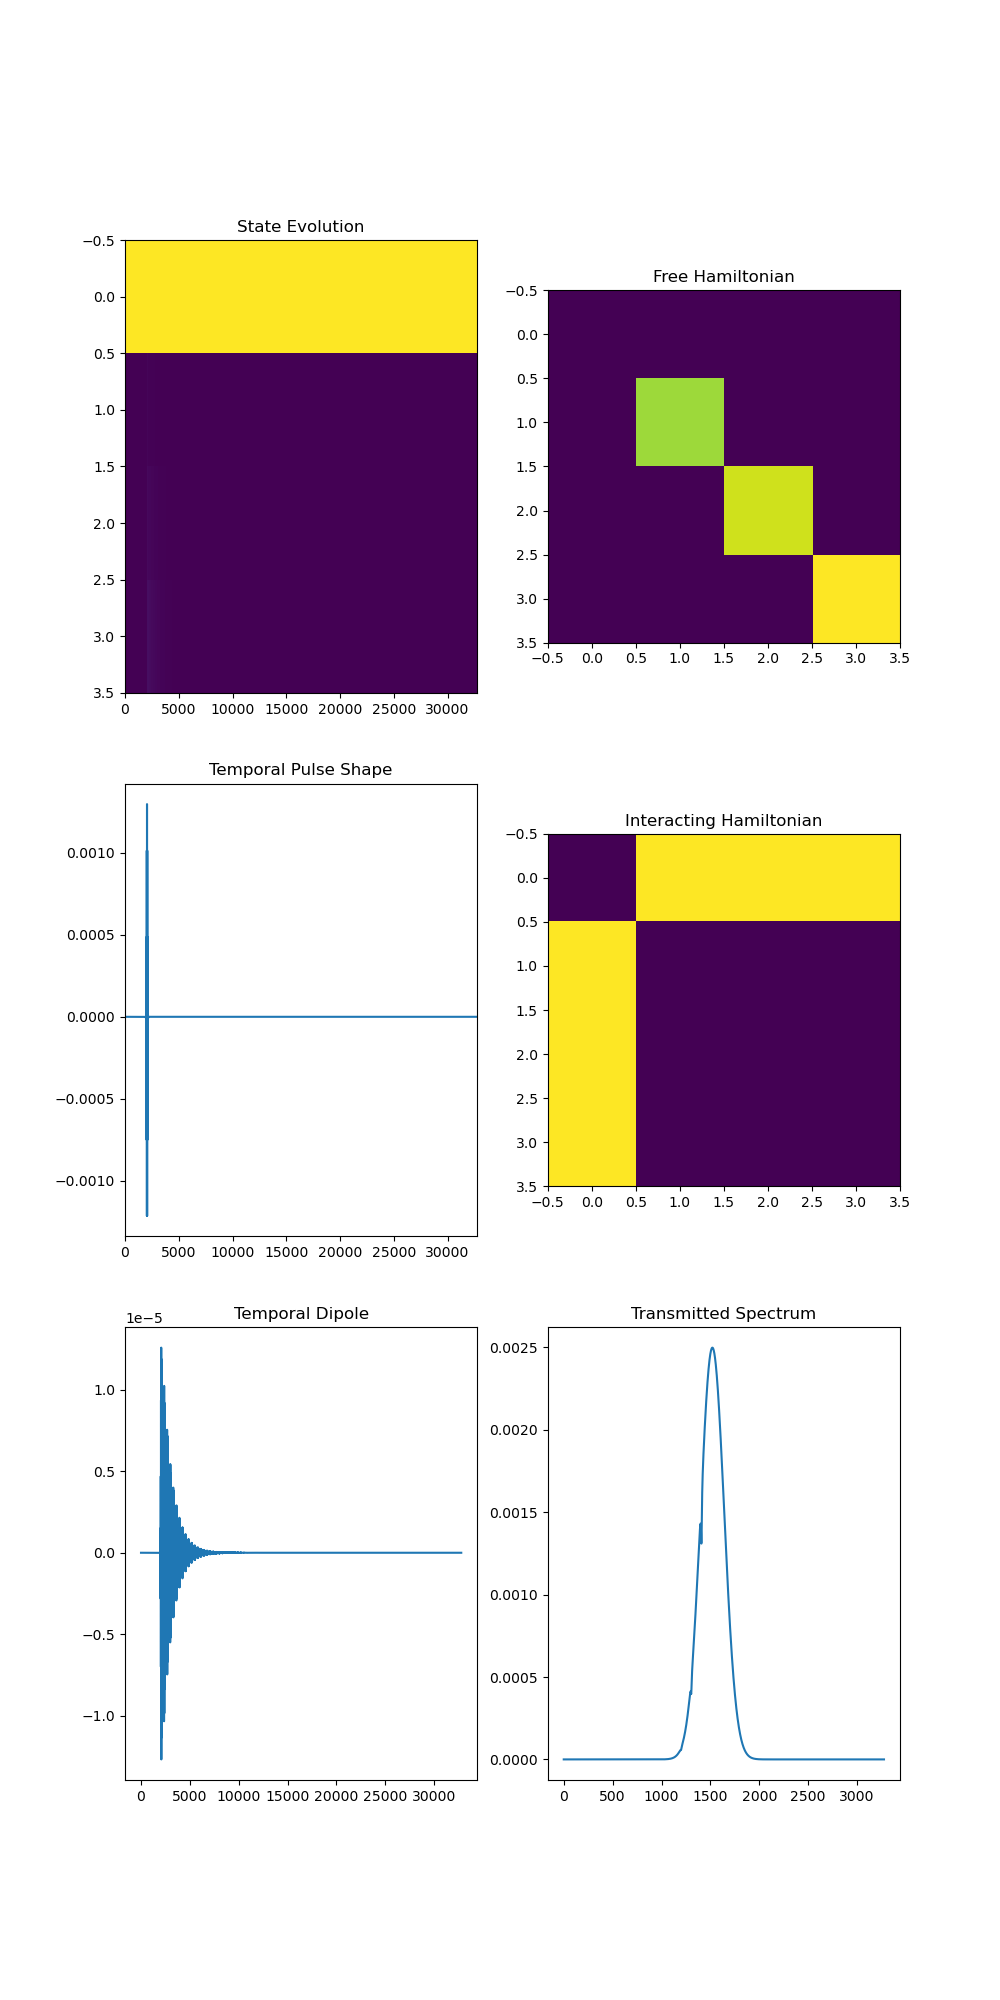

In [42]:
# Define figures
fig = plt.figure(figsize=(10,20))
ax = [fig.add_subplot().axis('off')]*(6)
ax[0] = fig.add_subplot(321)
ax[1] = fig.add_subplot(322)
ax[2] = fig.add_subplot(323)
ax[3] = fig.add_subplot(324)
ax[4] = fig.add_subplot(325)
ax[5] = fig.add_subplot(326)
 
ax[0].imshow(abs(StateHistory.T),aspect='auto', interpolation='none')
ax[0].set_title("State Evolution")
ax[2].plot(np.real(Pulse[0:len(Pulse)-1]))
ax[2].set_title("Temporal Pulse Shape")
ax[2].margins(x=0)
ax[1].imshow(abs(InitialHamiltonian))
ax[1].set_title("Free Hamiltonian")
ax[3].imshow(abs(CoupledHamiltonian))
ax[3].set_title("Interacting Hamiltonian")
ax[4].plot(Dipole.real)
ax[4].set_title("Temporal Dipole")
ax[5].plot(Spectrum[0:int((stepsCont+steps)/10)])
ax[5].set_title("Transmitted Spectrum")


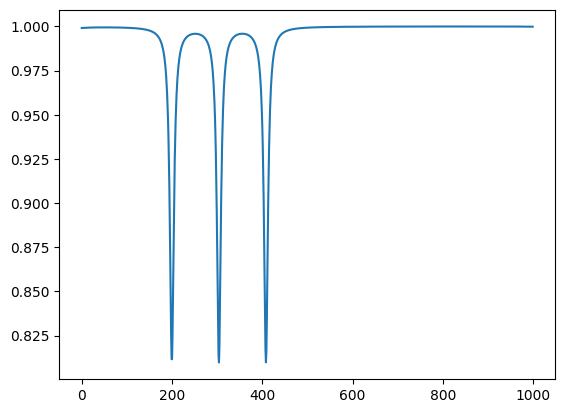

In [25]:
OD=Spectrum/(abs(Pulsespec)**2+0.0000000001)
plt.plot(OD[1000:2000])

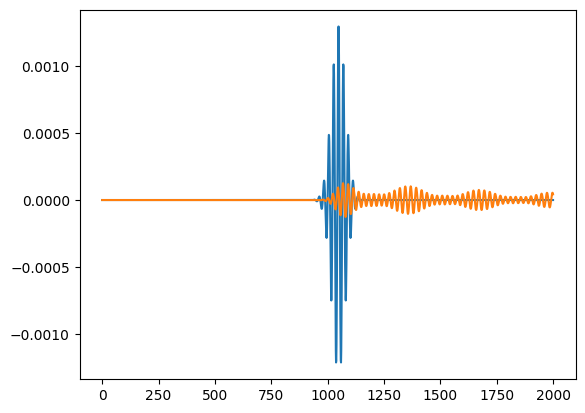

In [26]:
plt.plot(Pulse[1000:3000])
plt.plot(Dipole[1000:3000]*10)

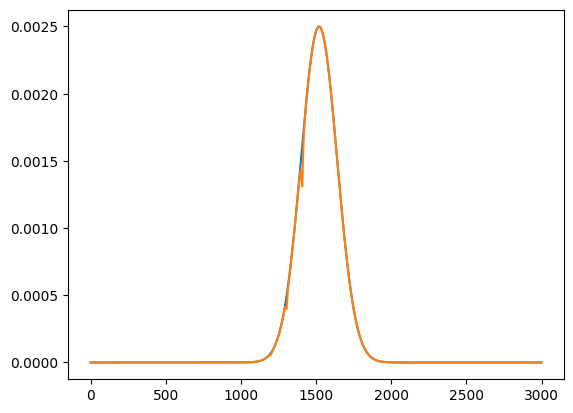

In [27]:
plt.plot(abs(Pulsespec**2)[0:3000])
plt.plot(Spectrum[0:3000])